In [ ]:
import minima as mi
from functools import partial

In [ ]:
import minima as mi
import numpy as np
import minima.nn as nn
import minima.optim as optim
from minima.data import *
import IPython.display as ipd

In [ ]:
def normalize(data):
    mean = np.mean(data)
    std = np.std(data)
    normalized_data = (data - mean) / std
    return normalized_data

In [ ]:
from data_split import data_split
X_train, y_train, X_valid, y_valid = data_split('data/data.csv')

X_train = normalize(X_train)
X_valid = normalize(X_valid)

In [ ]:
X_train.shape, y_train.shape

((454, 30), (454,))

In [ ]:
X_valid.shape, y_valid.shape

((114, 30), (114,))

In [ ]:
type(X_train)

numpy.ndarray

In [ ]:
X_tr, y_tr, X_val, y_val = map(mi.Tensor, (X_train, y_train, X_valid, y_valid))

In [ ]:
type(X_tr), y_tr[10:20]

(minima.autograd.Tensor, mi.Tensor([1 1 1 1 1 1 1 1 0 0]))

In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_shape, output_shape):
        super(NeuralNetwork, self).__init__()
        self.dense1 = nn.Linear(in_features=input_shape, out_features=100)
        self.dense2 = nn.Linear(100, 50)
        self.dense3 = nn.Linear(50, 25)
        self.dense4 = nn.Linear(25, output_shape)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax()

    def forward(self, x):
        x = self.relu(self.dense1(x))
        x = self.relu(self.dense2(x))
        x = self.relu(self.dense3(x))
        # print(self.dense4(x))
        x = self.dense4(x)
        return x

# Create the neural network
input_shape = X_tr.shape[1]  # Replace with the actual input shape
output_shape = 2  # Replace with the actual output shape

network = NeuralNetwork(input_shape, output_shape)
network

NeuralNetwork(
  (dense1): Linear(in_features=30, out_features=100, bias=True)
  (dense2): Linear(in_features=100, out_features=50, bias=True)
  (dense3): Linear(in_features=50, out_features=25, bias=True)
  (dense4): Linear(in_features=25, out_features=2, bias=True)
  (relu): ReLU()
  (softmax): Softmax()
)

In [ ]:
# Custom Dataset class
class MyDataset(Dataset):
    def __init__(self, X, y):
        self.X = mi.Tensor(X)
        self.y = mi.Tensor(y)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, index):
        return self.X[index], self.y[index]

tr_ds = MyDataset(X_tr, y_tr)
val_ds = MyDataset(X_val, y_val)

# Creating the data loader
bs = 128
tr_dl = DataLoader(tr_ds, batch_size=bs, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=bs, shuffle=False)

In [ ]:
xb, yb = next(iter(tr_dl))
xb.shape, yb

((128, 30),
 mi.Tensor([0 0 0 0 1 0 1 0 0 0 0 1 1 1 0 1 0 0 1 1 0 1 1 0 0 0 0 1 0 0 0 1 1 1 0 0 0 0 1 0 1 1 0 1 0 1 0 1 0 0 0 1 1 1 0 1 0 1 1 1 1 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0 0 0 1
  1 1 0 0 1 1 1 1 0 0 1 0 0 1 0 1 1 1 1 0 0 0 1 1 0 0 1 0 1 0 0 0 0 1 1 0 0 1 1 1 1 1 0 1 1 0 1 0 1]))

In [ ]:
xb.numpy().mean(), xb.numpy().std()

(0.013998925073509805, 1.0432548803778134)

In [ ]:
def train():
    network = NeuralNetwork(input_shape, output_shape)
    opt = optim.SGD(network.parameters(), lr=0.01)
    bce = nn.CrossEntropyLoss()
    
    network.train()
    num_epochs = 10
    
    for epoch in range(num_epochs):
        
        # Training phase
        network.train()
        tot_loss,tot_acc,count = 0.,0.,0
        for xb, yb in tr_dl:
            preds = network(xb)
            loss = bce(preds, yb)
            # import pdb; pdb.set_trace()
            loss.backward()
            opt.step()
            opt.zero_grad()
            
            # Calculate accuracy & loss
            predicted_labels = preds.argmax(axis=1)
            n = len(xb)
            count += n
            tot_loss += loss.item()*n
            tot_acc  += mi.Tensor.accuracy(predicted_labels, yb).item()*n
        
        # Print epoch-wise loss and accuracy
        # print(f"epoch {epoch + 1:02d}/{num_epochs:02d} - loss: {avg_train_loss:.4f} - acc: {avg_train_acc:.4f} - val_loss: {avg_val_loss:.4f} - val_acc: {avg_val_acc:.4f}")
        print(f"epoch {epoch + 1:02d}/{num_epochs:02d} - loss: {tot_loss/count:.4f} - acc: {tot_acc/count:.4f}")


In [ ]:
# train()

In [ ]:
from tqdm.notebook import tqdm
from IPython.display import display, HTML

In [ ]:
def fit(epochs, lr, model, loss_func, opt_fn, train_dl, valid_dl):
    recorder = {'tr_loss': [], 'val_loss': [], 'tr_acc': [], 'val_acc': []}
    losses = [[], []]
    fig, axs = plt.subplots(1, 1, figsize=(16, 6))
    p = display(fig,display_id=True)

    opt = opt_fn(model.parameters(), lr=lr, wd=0.2, momentum=0.9)
    for epoch in tqdm(range(epochs)):
        model.train()
        train_tot_loss, train_tot_acc, t_count = 0.,0.,0
        for xb,yb in train_dl:
            preds = model(xb)
            loss = loss_func(preds, yb)
            loss.backward()
            opt.step()
            opt.zero_grad()

            # Calculate accuracy & loss
            predicted_labels = preds.argmax(axis=1)
            n = len(xb)
            t_count += n
            train_tot_loss += loss.item()*n
            train_tot_acc  += mi.Tensor.accuracy(predicted_labels, yb).item()*n
            recorder['tr_loss'].append(loss.item())
            recorder['tr_acc'].append(mi.Tensor.accuracy(predicted_labels, yb).item())
            losses[0].append(loss.item())
            

            

        model.eval()
        val_tot_loss, val_tot_acc,v_count = 0.,0.,0
        for xb,yb in valid_dl:
            preds = model(xb)

            pred_labels = preds.argmax(axis=1)
            n = len(xb)
            v_count += n
            val_tot_acc  += mi.Tensor.accuracy(pred_labels, yb).item()*n
            val_tot_loss += loss_func(preds,yb).item()*n
            recorder['val_loss'].append(loss_func(preds,yb).item())
            recorder['val_acc'].append(mi.Tensor.accuracy(pred_labels, yb).item())
            losses[1].append(loss_func(preds,yb).item())

            
        print(f"epoch {epoch + 1:02d}/{epochs:02d} - loss: {train_tot_loss/t_count:.4f} - acc: {train_tot_acc/t_count:.4f} - val_loss: {val_tot_loss/v_count:.4f} - val_acc: {val_tot_acc/v_count:.4f}")
        
        axs.plot(losses[0], label='Train loss:')
        axs.plot(losses[1], label='Validation loss:')
        p.update(fig)

    # ipd.clear_output()
    # p.update(fig)    
    return recorder

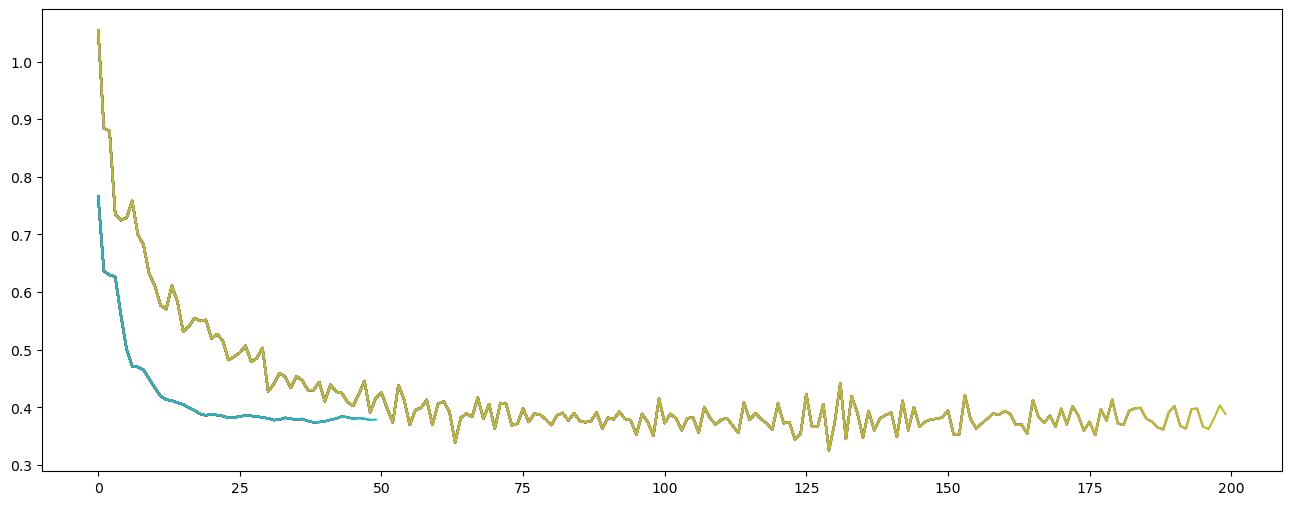

  0%|          | 0/50 [00:00<?, ?it/s]

epoch 01/50 - loss: 0.9079 - acc: 0.4075 - val_loss: 0.7650 - val_acc: 0.2281
epoch 02/50 - loss: 0.7315 - acc: 0.4141 - val_loss: 0.6362 - val_acc: 0.8158
epoch 03/50 - loss: 0.6315 - acc: 0.7907 - val_loss: 0.6298 - val_acc: 0.6316
epoch 04/50 - loss: 0.5793 - acc: 0.7511 - val_loss: 0.6267 - val_acc: 0.6228
epoch 05/50 - loss: 0.5489 - acc: 0.8216 - val_loss: 0.5604 - val_acc: 0.8246
epoch 06/50 - loss: 0.5147 - acc: 0.8965 - val_loss: 0.5010 - val_acc: 0.9474
epoch 07/50 - loss: 0.4937 - acc: 0.8811 - val_loss: 0.4714 - val_acc: 0.9474
epoch 08/50 - loss: 0.4671 - acc: 0.8943 - val_loss: 0.4699 - val_acc: 0.9298
epoch 09/50 - loss: 0.4496 - acc: 0.9097 - val_loss: 0.4651 - val_acc: 0.8860
epoch 10/50 - loss: 0.4368 - acc: 0.9119 - val_loss: 0.4493 - val_acc: 0.8947
epoch 11/50 - loss: 0.4255 - acc: 0.9141 - val_loss: 0.4340 - val_acc: 0.9298
epoch 12/50 - loss: 0.4167 - acc: 0.9009 - val_loss: 0.4195 - val_acc: 0.9386
epoch 13/50 - loss: 0.4090 - acc: 0.8987 - val_loss: 0.4133 - va

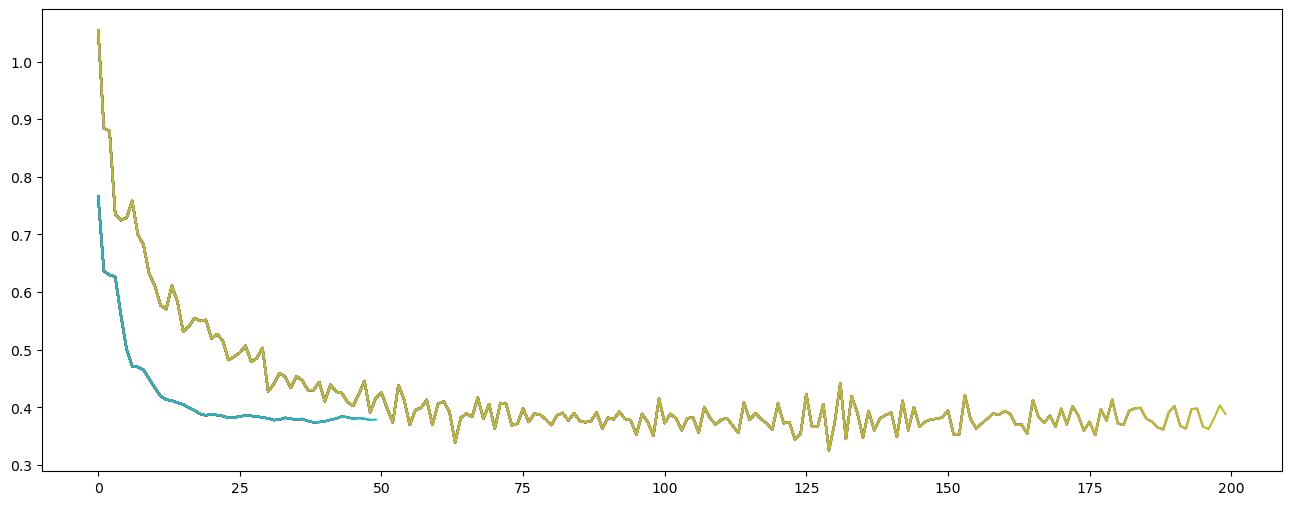

In [ ]:
network = NeuralNetwork(input_shape, output_shape)
recorder = fit(50, 0.05, network, nn.CrossEntropyLoss(), optim.SGD, tr_dl, val_dl)

In [ ]:
import matplotlib.pyplot as plt

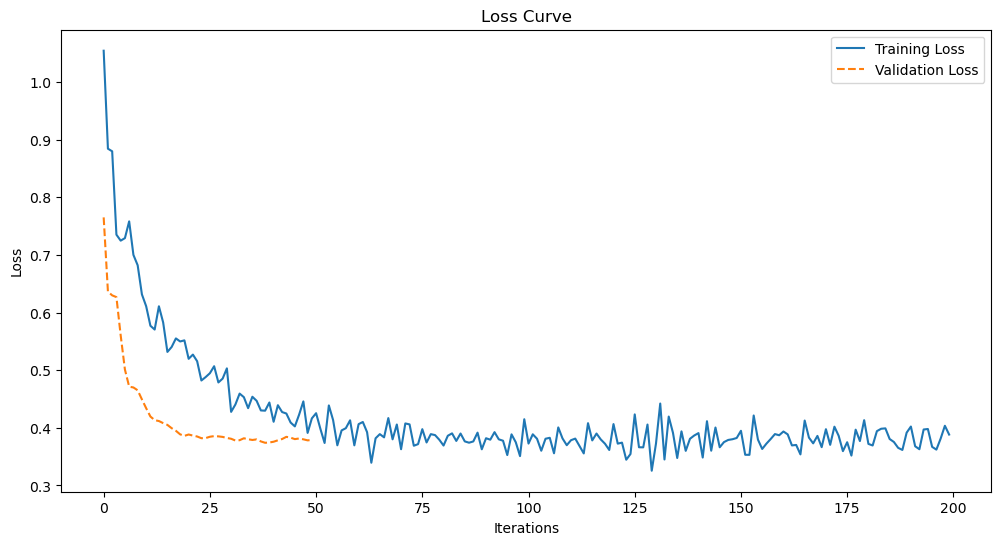

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(recorder['tr_loss'], label='Training Loss')
plt.plot(recorder['val_loss'], label='Validation Loss', linestyle='--')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curve')
plt.show()

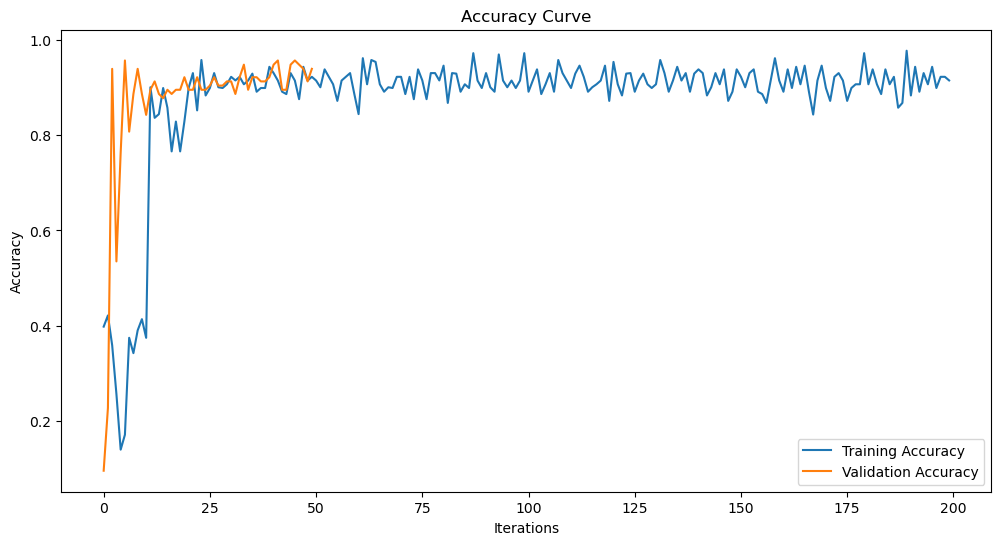

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(recorder['tr_acc'], label='Training Accuracy')
plt.plot(recorder['val_acc'], label='Validation Accuracy')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Curve')
plt.show()

In [ ]:
len(recorder['tr_acc']), len(recorder['val_acc'])

(200, 50)